In [29]:
from lsst.daf.butler import Butler
import pandas as pd
from pfs.datamodel import TargetType

In [2]:
# Change the output collection to match your ticket, e.g. wtg/tickets/PIPE2D-1234
OUTPUT_COLLECTION = 'u/wtg/example'

In [5]:
# These probably dont' need to change.
DATASTORE = '/work/datastore/'
COLLECTIONS = 'PFS/default'
INSTRUMENT = 'lsst.obs.pfs.PrimeFocusSpectrograph'

# These are the pipelines that we are running.
REDUCE_PIPELINE_PATH = '$DRP_STELLA_DIR/pipelines/reduceExposure.yaml'
QA_PIPELINE_PATH = f'/work/wtg/drp_qa_dev/pipelines/drpQA.yaml'

# Pipeline run options
NUM_JOBS = 50

## Run `reduceExposure` pipeline

This will generate the `lines` and adjusted `detectorMap` objects we use for the DetectorMap QA.

We use the `!` operator to call the `pipetask` command the same as we would in a shell. 

Here we are just processing a simple set of calibration exposures, a Quartz and one of each lamp line, which we will define in our data_select string.

In [4]:
data_select = "visit in (114641, 114644, 114647, 114651, 114655, 114659) and arm in ('b', 'r', 'n')"

In [6]:
!pipetask \
    --long-log \
    --log-tty \
    --log-level "pfs=INFO" \
    run \
    -b {DATASTORE} \
    -j {NUM_JOBS} \
    --instrument {INSTRUMENT} \
    -i {COLLECTIONS} \
    -o {OUTPUT_COLLECTION} \
    -p {REDUCE_PIPELINE_PATH} \
    -d "{data_select}"

## Run `drpQA` pipeline

The `detectorMapQa` runs a number of separate QA related tasks.

We specify a few options to show the syntax but the default options should be okay for most processing.

In [7]:
use_sigma = False
spatial_range = 0.1
wavelength_range = 0.1

In [ ]:
!setup -jr /work/wtg/display_matplotlib && pipetask \
    --long-log \
    --log-tty \
    run \
    --register-dataset-types \
    -b {DATASTORE} \
    -j 50 \
    --instrument {INSTRUMENT} \
    -i {COLLECTIONS} \
    -o {OUTPUT_COLLECTION} \
    -p "/work/wtg/drp_qa_dev/pipelines/drpQA.yaml" \
    -d "{data_select}" \
    -c dmResiduals:useSigmaRange={use_sigma} \
    -c dmResiduals:spatialRange={spatial_range} \
    -c dmResiduals:wavelengthRange={wavelength_range} \
    --fail-fast

## Get stored objects from the butler

We use the `OUTPUT_COLLECTION` to look up the objects stored by the tasks.

In [18]:
butler = Butler(DATASTORE, collections=OUTPUT_COLLECTION)


The QA task for individual visits produces a plot (saved as a `.png` image)
and a `pandas.DataFrame` that has two rows of statistics, one for the `USED`
points and one for the `RESERVED` points.

The `USED` points come from the adjustment itself and the `RESERVED` points are
 what we want to do the QA checks on.

The statistics are stored under the `dmQaResidualStats` and the plot is `dmQaResidualPlot`. These both require the `(arm, spectrograph, visit)` dimensions, which we define here as a traditional DataId.

In [41]:
data_id = dict(arm='b', spectrograph=2, visit=114641)

### DetectorMap

#### dmQaResidualStats

Statistics for an individual detector for a given visit.

In [42]:
# Show the RESERVED and USED stats for the given detector visit.
butler.get('dmQaResidualStats', data_id).T

,0,0
dof,226107.0,2034231.0
chi2X,1105195.51935,9943420.906886
chi2Y,0.0,0.0
spatial.median,0.000205,0.00031
spatial.robustRms,0.030872,0.030991
spatial.weightedRms,0.028375,0.028357
spatial.softenFit,0.025675,0.02567
spatial.dof,226107.0,2034231.0
spatial.num_fibers,586,586
spatial.num_lines,226107,2034231


#### dmQaResidualPlot

The 2D residaul plot of an indvidual detector for a given visit.

The residual plots are stored as `png` images and the butler can only return a path to those objects, but we can display those in a notebook using the path.

In [43]:
butler.getURI('dmQaResidualPlot', data_id)

ResourcePath("file:///work/datastore/u/wtg/example/20241024T021331Z/dmQaResidualPlot/dmQaResidualPlot_PFS_114641_b2_u_wtg_example_20241024T021331Z.png")

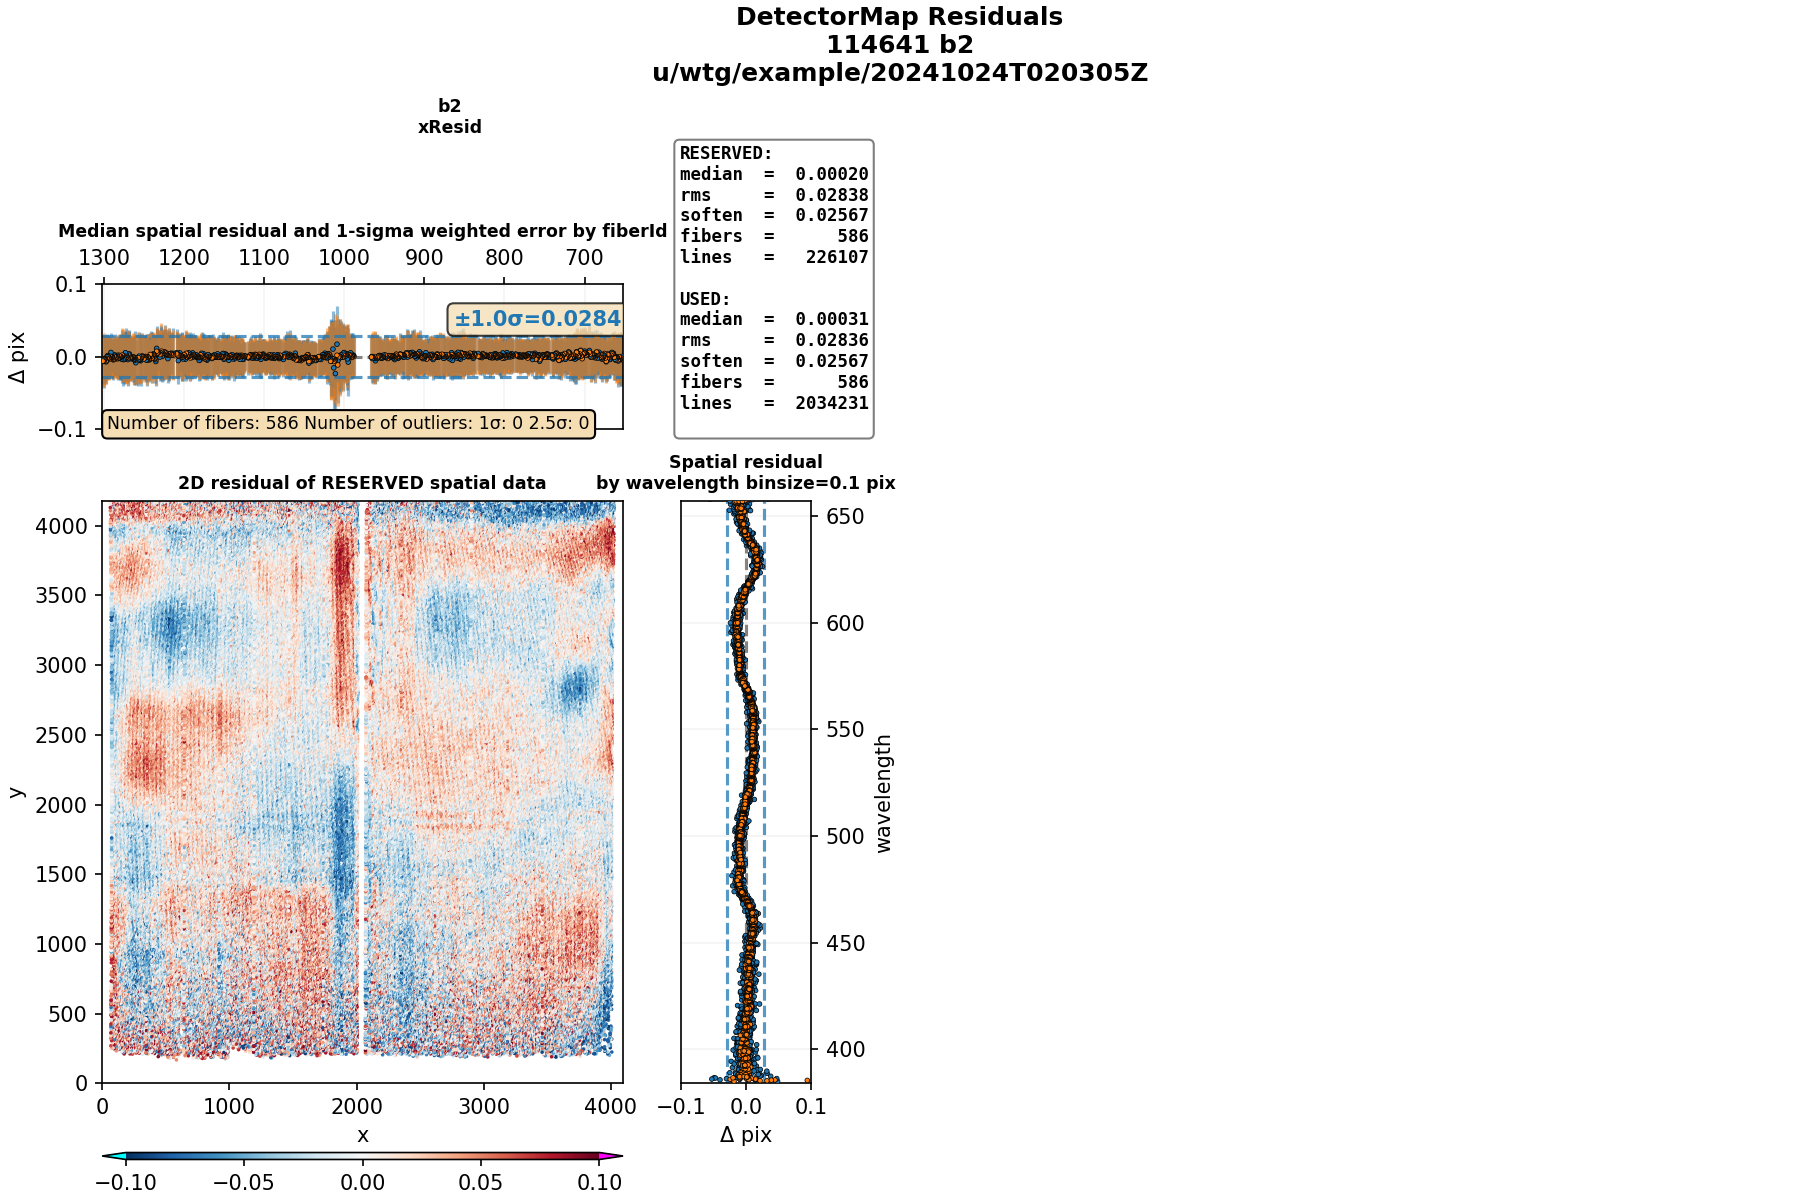

In [44]:
# Use the .unquoted_path property.
from IPython.display import Image
Image(filename=butler.getURI('dmQaResidualPlot', data_id).unquoted_path)

#### dmQaDetectorStats

Aggregate detector stats for all decector and visit combinations in the collection.

In [45]:
butler.get('dmQaDetectorStats').head()

,dof,chi2X,chi2Y,spatial.median,spatial.robustRms,spatial.weightedRms,spatial.softenFit,spatial.dof,spatial.num_fibers,spatial.num_lines,...,spectrograph,visit,ccd,description,detector_width,detector_height,fiberId_min,fiberId_max,wavelength_min,wavelength_max
0,226062.0,8.928344e+05,0.0,0.000349,0.029218,0.026299,0.022882,226062.0,585,226062,...,1,114641,b1,Trace,4096,4176,1,651,386,659
0,226107.0,1.105196e+06,0.0,0.000205,0.030872,0.028375,0.025675,226107.0,586,226107,...,2,114641,b2,Trace,4096,4176,652,1302,384,657
0,225384.0,6.862884e+05,0.0,0.000321,0.027566,0.024532,0.020246,225384.0,596,225384,...,3,114641,b3,Trace,4096,4176,1303,1953,382,659
0,226992.0,7.445131e+05,0.0,0.000040,0.027987,0.024958,0.021027,226992.0,587,226992,...,4,114641,b4,Trace,4096,4176,1954,2604,379,659
0,187216.0,4.555164e+06,0.0,0.000137,0.026121,0.025879,0.026268,187216.0,585,187216,...,1,114641,n1,Trace,4096,4096,1,651,930,1267


#### dmQaCombinedResidualPlot

A multi-page pdf report that shows aggregate plot statistics based on the `dmQaDetectorStats` data above.

Like images, the butler cannot directly display a PDF but only return a path. We can copy that file from the datastore to the local directory to look at it.

In [46]:
butler.getURI('dmQaCombinedResidualPlot')

ResourcePath("file:///work/datastore/u/wtg/example/20241024T021331Z/dmQaCombinedResidualPlot/dmQaCombinedResidualPlot_PFS_u_wtg_example_20241024T021331Z.pdf")

In [47]:
# Copy the file to our local directory
!cp {butler.getURI('dmQaCombinedResidualPlot').unquoted_path} .

### Extraction QA

#### extQaStats

In [48]:
!cp {butler.getURI('extQaStats', data_id).unquoted_path} .

#### extQaImage

In [49]:
!cp {butler.getURI('extQaImage', data_id).unquoted_path} .

#### extQaImage_pickle

In [50]:
extraction_stats = butler.get('extQaImage_pickle', data_id)

In [51]:
fiber_stats = pd.DataFrame({
    'fiberIds': extraction_stats['fiberIds'],
    'xa': extraction_stats['xa'],
    'pfsArmAve': extraction_stats['pfsArmAve'],
    'chiSquare': extraction_stats['chiSquare'],
    'chiMedian': extraction_stats['chiMedian'],
    'chiStd': extraction_stats['chiStd'],
    'chiPeak': extraction_stats['chiPeak'],
})

In [52]:
stats = pd.DataFrame({
    'fiberId': extraction_stats['fiberIDarray'],
    'X': extraction_stats['Xarray'],
    'Y': extraction_stats['Yarray'],
    'dX': extraction_stats['dx'],
    'dX_sigma': extraction_stats['dsigma'],
})

In [53]:
for tt, data in extraction_stats['targetMask'].items():
    fiber_stats[f'is_{tt.name.lower()}'] = data

In [54]:
fiber_stats

,fiberIds,xa,pfsArmAve,chiSquare,chiMedian,chiStd,chiPeak,is_science,is_sky,is_fluxstd,is_unassigned,is_engineering,is_sunss_imaging,is_sunss_diffuse,is_dcb,is_home,is_blackspot,is_afl
0,653,4010.187447,21672.498047,9.036757,1.049021,2.519202,-0.478302,False,False,False,False,False,False,False,False,True,False,False
1,654,4003.922884,14011.454102,6.624696,0.599913,2.041184,-0.302809,False,False,False,False,False,False,False,False,True,False,False
2,655,3997.751135,21911.226562,20.200151,0.565189,2.124652,-0.544934,False,False,False,False,False,False,False,False,True,False,False
3,656,3991.478206,22844.701172,7.583621,0.528812,2.134532,-0.437813,False,False,False,False,False,False,False,False,True,False,False
4,657,3985.229756,22773.984375,7.960407,0.573361,2.179661,-0.412167,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,1297,96.678923,20748.281250,55.520508,0.531809,1.785862,-0.738350,False,False,False,False,False,False,False,False,True,False,False
582,1298,90.391588,18732.572266,5.619014,0.557797,1.806162,-0.420675,False,False,False,False,False,False,False,False,True,False,False
583,1299,84.096303,18337.753906,5.376155,0.579792,1.834322,-0.514284,False,False,False,False,False,False,False,False,True,False,False
584,1300,77.832209,18718.224609,5.607858,0.621894,1.796205,-0.430434,False,False,False,False,False,False,False,False,True,False,False


In [55]:
stats

,fiberId,X,Y,dX,dX_sigma
0,653,4008,187,0.018252,-0.200221
1,653,4007,208,-0.002174,-0.180332
2,653,4007,250,0.113503,-0.061790
3,653,4007,271,-0.028459,-0.052329
4,653,4007,292,-0.091648,-0.090586
...,...,...,...,...,...
106488,1301,64,4071,-0.027562,-0.115921
106489,1301,64,4092,-0.037243,-0.141667
106490,1301,63,4113,-0.055038,-0.139357
106491,1301,63,4134,-0.057936,-0.167299
